# Higgs To 4 Leptons Analysis with Systematic Uncertainties Using uproot, pandas and pyhf

## Imports and Variable Initialization

This is where we state the location of our .root files. To reduce the memory usage, we select which columns of the .root files will be used when building our dataframes.

In [1]:
# original: https://root.cern.ch/doc/v622/df106__HiggsToFourLeptons_8py.html
from collections import Counter

import os
import math
import json
import glob

from pprint import pprint as pp

from datetime import datetime
t1 = datetime.now()
print(t1)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import uproot
import mplhep
from skhep.math.vectors import LorentzVector

plt.style.use(mplhep.style.ATLAS)

path = "root://eospublic.cern.ch//eos/opendata/atlas/OutreachDatasets/2020-01-22"
path = "/home/zbhatti/codebase/intro-to-hep/OutreachDatasets/2020-01-22"
files = json.load(open(os.path.join(os.environ["ROOTSYS"], "tutorials/dataframe", "df106_HiggsToFourLeptons.json")))
pp(files)
use_cached = True
lumi = 10064.0

read_columns = ['trigE', 'trigM', 'lep_eta', 'lep_pt', 'lep_ptcone30', 'lep_etcone20', 
                'lep_type', 'lep_charge', 'lep_phi', 'lep_E', 'lep_trackd0pvunbiased', 
                'lep_tracksigd0pvunbiased', 'lep_z0', 'mcWeight', 'scaleFactor_ELE', 
                'scaleFactor_MUON', 'scaleFactor_LepTRIGGER', 'scaleFactor_PILEUP',
               ]

dataframes_pickle_filename = 'higgs_4l_dataframes-{}-.pkl'
cut_counts_pickle_filename = 'higgs_4l_cut_counts-{}-.pkl'

processes = files.keys()
dataframes = {}
xsecs = {}
sumws = {}
samples = []
cut_counts = {}

2020-10-12 06:59:20.339313
{'data': [['Data', 'data_A', 1, 1],
          ['Data', 'data_B', 1, 1],
          ['Data', 'data_C', 1, 1],
          ['Data', 'data_D', 1, 1]],
 'higgs': [['MC', 'mc_345060.ggH125_ZZ4lep', 0.0060239, 27881776.6536],
           ['MC', 'mc_344235.VBFH125_ZZ4lep', 0.0004633012, 3680490.83243]],
 'other': [['MC', 'mc_361106.Zee', 1950.5295, 150277594200],
           ['MC', 'mc_361107.Zmumu', 1950.6321, 147334691090]],
 'zz': [['MC', 'mc_363490.llll', 1.2578, 7538705.8077]]}


## Load .root Files and Apply Cuts

Here we apply cuts, reducing the total number of events we eventually bin into histograms. Using existing or defining new columns helps us make the right choice of filters to apply.

In [2]:
def cut_trigE_trigM(trigE, trigM):
    return np.logical_not(np.logical_or(trigE, trigM))

# https://github.com/scikit-hep/scikit-hep/blob/master/skhep/math/vectors.py#L700
def good_electrons_and_muons(pdg_id, pt, eta, phi, e, trackd0pv, tracksigd0pv, z0):
    for i in range(0, len(pdg_id)):
        p = LorentzVector()
        p.setptetaphie(pt[i] / 1000.0, eta[i], phi[i], e[i] / 1000.0)
        if pdg_id[i] == 11:
            if (pt[i] < 7000 or abs(eta[i]) > 2.47 or abs(trackd0pv[i] / tracksigd0pv[i]) > 5 or abs(z0[i] * math.sin(p.theta())) > 0.5):
                return False
        else:
            if (abs(trackd0pv[i] / tracksigd0pv[i]) > 5 or abs(z0[i] * math.sin(p.theta())) > 0.5):
                return False
    return True

# https://stackoverflow.com/questions/40045632/adding-a-column-in-pandas-df-using-a-function
def good_lep(lep_eta, lep_pt, lep_ptcone30, lep_etcone20):
    a = np.logical_and(abs(lep_eta) < 2.5, lep_pt > 5000)
    b = np.logical_and(lep_ptcone30 / lep_pt < 0.3, lep_etcone20 / lep_pt < 0.3)
    return np.logical_and(a, b)

def invariant_mass(pt, eta, phi, E):
    leptons = []
    for i in range(0, 4):
        p = LorentzVector()
        p.setptetaphie(pt[i], eta[i], phi[i], E[i])
        leptons.append(p)
    
    return (leptons[0] + leptons[1] + leptons[2] + leptons[3]).m / 1000.0;

def build_dataframe(tree, xsecs_sample, sumws_sample, data_or_mc):
    dataframes = None
    cut_counts = np.array([0, 0, 0, 0, 0, 0, 0])
    
    for df in tree.iterate(read_columns, outputtype=pd.DataFrame):
            print(df.shape)
            sample_batch_counts = [df.shape[0]]
            
            # Filter 1
            df = df[df.trigE | df.trigM]
            sample_batch_counts.append(df.shape[0])

            df['good_lep'] = df.apply(lambda x: good_lep(x.lep_eta, x.lep_pt, x.lep_ptcone30, x.lep_etcone20), axis=1)

            # Filter 2
            df = df[df.apply(lambda x: x.good_lep.sum() == 4, axis=1)]
            sample_batch_counts.append(df.shape[0])
            
            # Filter 3
            df = df[df.apply(lambda x: x.lep_charge[x.good_lep].sum() == 0, axis=1)]
            sample_batch_counts.append(df.shape[0])

            df['goodlep_sumtypes'] = df.apply(lambda x: x.lep_type[x.good_lep].sum(), axis=1)
            
            # Filter 4
            df = df[(df.goodlep_sumtypes == 44) | (df.goodlep_sumtypes == 52) | (df.goodlep_sumtypes == 48)]
            sample_batch_counts.append(df.shape[0])
            
            # Filter 5
            df = df[df.apply(lambda x: good_electrons_and_muons(x.lep_type[x.good_lep], 
                                                                x.lep_pt[x.good_lep], 
                                                                x.lep_eta[x.good_lep], 
                                                                x.lep_phi[x.good_lep], 
                                                                x.lep_E[x.good_lep], 
                                                                x.lep_trackd0pvunbiased[x.good_lep], 
                                                                x.lep_tracksigd0pvunbiased[x.good_lep], 
                                                                x.lep_z0[x.good_lep]), 
                             axis=1)]
            sample_batch_counts.append(df.shape[0])
            
            df['goodlep_pt'] = df.apply(lambda x: x.lep_pt[x.good_lep], axis=1)
            df['goodlep_eta'] = df.apply(lambda x: x.lep_eta[x.good_lep], axis=1)
            df['goodlep_phi'] = df.apply(lambda x: x.lep_phi[x.good_lep], axis=1)
            df['goodlep_E'] = df.apply(lambda x: x.lep_E[x.good_lep], axis=1)
            
            # Filter 6
            lep_pt_threshold = 8000 or 10000 or 12000
            df = df[df.apply(lambda x: x.goodlep_pt[0] > 25000 and 
                                       x.goodlep_pt[1] > 15000 and 
                                       x.goodlep_pt[2] > 10000, 
                             axis=1)]
            sample_batch_counts.append(df.shape[0])
            df['m4l'] = df.apply(lambda x: invariant_mass(x.goodlep_pt, 
                                                          x.goodlep_eta, 
                                                          x.goodlep_phi, 
                                                          x.goodlep_E), 
                                 axis=1)
            
            if "data" in data_or_mc:
                df['weight'] = df.apply(lambda x: 1.0, axis=1)
            elif "mc" in data_or_mc:
                df['weight'] = df.apply(lambda x: x.scaleFactor_ELE * 
                                                  x.scaleFactor_MUON * 
                                                  x.scaleFactor_LepTRIGGER * 
                                                  x.scaleFactor_PILEUP * 
                                                  x.mcWeight * 
                                                  (xsecs_sample / sumws_sample) * lumi, 
                                        axis=1)
            
            # free up memory
            drop_columns = list(set(df.columns) - set(['m4l', 'weight']))
            df.drop(drop_columns, axis=1, inplace=True)
            
            print (df.shape)
            cut_counts = np.array(sample_batch_counts) + cut_counts
            
            if dataframes is None: 
                dataframes = df
                
            else:
                dataframes = dataframes.append(df) 
        
    return dataframes, cut_counts

In [3]:
for p in processes:
    for d in files[p]:
        # Construct the dataframes
        folder = d[0] # Folder name
        sample = d[1] # Sample name
        xsecs[sample] = d[2] # Cross-section
        sumws[sample] = d[3] # Sum of weights
        samples.append(sample)
        filepath = "{}/4lep/{}/{}.4lep.root".format(path, folder, sample)
        print(sample, filepath)
        uproot_file = uproot.open(filepath)
        tree = uproot_file['mini']
        data_or_mc = "data" if "data" in sample.lower() else "mc"
        
        if not use_cached:
            dataframes[sample], cut_counts[sample] = build_dataframe(tree, xsecs[sample], sumws[sample], data_or_mc)        
            dataframes[sample].to_pickle(dataframes_pickle_filename.format(sample))
            np.save(cut_counts_pickle_filename.format(sample), cut_counts[sample])


data_A /home/zbhatti/codebase/intro-to-hep/OutreachDatasets/2020-01-22/4lep/Data/data_A.4lep.root
data_B /home/zbhatti/codebase/intro-to-hep/OutreachDatasets/2020-01-22/4lep/Data/data_B.4lep.root
data_C /home/zbhatti/codebase/intro-to-hep/OutreachDatasets/2020-01-22/4lep/Data/data_C.4lep.root
data_D /home/zbhatti/codebase/intro-to-hep/OutreachDatasets/2020-01-22/4lep/Data/data_D.4lep.root
mc_345060.ggH125_ZZ4lep /home/zbhatti/codebase/intro-to-hep/OutreachDatasets/2020-01-22/4lep/MC/mc_345060.ggH125_ZZ4lep.4lep.root
mc_344235.VBFH125_ZZ4lep /home/zbhatti/codebase/intro-to-hep/OutreachDatasets/2020-01-22/4lep/MC/mc_344235.VBFH125_ZZ4lep.4lep.root
mc_363490.llll /home/zbhatti/codebase/intro-to-hep/OutreachDatasets/2020-01-22/4lep/MC/mc_363490.llll.4lep.root
mc_361106.Zee /home/zbhatti/codebase/intro-to-hep/OutreachDatasets/2020-01-22/4lep/MC/mc_361106.Zee.4lep.root
mc_361107.Zmumu /home/zbhatti/codebase/intro-to-hep/OutreachDatasets/2020-01-22/4lep/MC/mc_361107.Zmumu.4lep.root


## Load a Previous Run of the Cuts

Fortunately, the work done in the previous steps are a checkpoint. We can pick up our analysis here if we do not need to update the cuts

In [6]:
pickle_filenames = glob.glob(dataframes_pickle_filename.format('*'))
print(pickle_filenames)
if use_cached:
    for filename in pickle_filenames:
        sample = filename.split('-')[1]
        print('loading sample {}'.format(sample))
        dataframes[sample] = pd.read_pickle(filename)
#         cut_counts[sample] = np.load(cut_counts_pickle_filename.format(sample))
        samples.append(sample)

print('Final Shapes for Samples:')
pp(cut_counts)

['higgs_4l_dataframes-mc_345060.ggH125_ZZ4lep-.pkl', 'higgs_4l_dataframes-data_B-.pkl', 'higgs_4l_dataframes-data_A-.pkl', 'higgs_4l_dataframes-mc_344235.VBFH125_ZZ4lep-.pkl', 'higgs_4l_dataframes-mc_361107.Zmumu-.pkl', 'higgs_4l_dataframes-mc_361106.Zee-.pkl', 'higgs_4l_dataframes-mc_363490.llll-.pkl', 'higgs_4l_dataframes-data_C-.pkl', 'higgs_4l_dataframes-data_D-.pkl']
loading sample mc_345060.ggH125_ZZ4lep
loading sample data_B
loading sample data_A
loading sample mc_344235.VBFH125_ZZ4lep
loading sample mc_361107.Zmumu
loading sample mc_361106.Zee
loading sample mc_363490.llll
loading sample data_C
loading sample data_D
Final Shapes for Samples:
{}


## Efficiency of the Cuts

Here we see how the cuts reduce background events while not excluding potential signal events

In [7]:
cut_efficiency = pd.DataFrame()

# Merge Signal and BG counts
cut_efficiency['Signal N'] = cut_counts['mc_345060.ggH125_ZZ4lep'] + cut_counts['mc_344235.VBFH125_ZZ4lep']
cut_efficiency['Background N'] = cut_counts['mc_361106.Zee'] + cut_counts['mc_361107.Zmumu'] + cut_counts['mc_363490.llll']
cut_efficiency['Signal %'] = np.full((cut_counts['mc_361106.Zee'].shape[0], ), np.nan)
cut_efficiency['Background %'] = np.full((cut_counts['mc_361106.Zee'].shape[0], ), np.nan)

# Produce fractional numbers
for region_name in ['Signal', 'Background']:
    region_pct = region_name + ' %'
    region_n = region_name + ' N'
    for filter_i, count in enumerate(cut_efficiency[region_n]):
    
        if filter_i == 0:
            continue
        else:
            prev = cut_efficiency[region_n][filter_i-1]
            curr = cut_efficiency[region_n][filter_i]
            cut_efficiency[region_pct][filter_i] = abs(prev - curr) / prev * 100.

print('events passing each cut and percent difference from prev filter')
pp(cut_efficiency)

KeyError: 'mc_345060.ggH125_ZZ4lep'

## Merge Samples Into Background, Signal and Data Sets

Initially, our labeled data sets are split across multiple .root files

In [8]:
print('sample name and its data')
# merge with bin, low and high parameters taken from first histogram
def merge_series(label):
    x = None
    weights = None
    for i, d in enumerate(files[label]):
        sample = d[1]
        print('merging {}...'.format(sample))
        sample_x = dataframes[sample].m4l.to_numpy()
        sample_weights = dataframes[sample].weight.to_numpy()
        if i == 0: 
            x = sample_x
            weights = sample_weights
        else: 
            x = np.concatenate((x, sample_x), axis=None)
            weights = np.concatenate((weights, sample_weights), axis=None)
    return x, weights

data_x, data_weights = merge_series("data")
higgs_x, higgs_weights = merge_series("higgs")
zz_x, zz_weights = merge_series("zz")
other_x, other_weights = merge_series("other")

dataframes = {} # free up some precious memory

sample name and its data
merging data_A...
merging data_B...
merging data_C...
merging data_D...
merging mc_345060.ggH125_ZZ4lep...
merging mc_344235.VBFH125_ZZ4lep...
merging mc_363490.llll...
merging mc_361106.Zee...
merging mc_361107.Zmumu...


## Build Histograms

Now that all our labeled sets are complete, we can start building histograms and finding the statistical uncertainties for each bin

In [9]:
n_bins = 24
bin_range = (80, 170)
bin_edges = np.linspace(bin_range[0], bin_range[1], n_bins)
center_offset = (bin_range[1] - bin_range[0]) / n_bins /2. 
bin_centers = np.linspace(bin_range[0]+center_offset, bin_range[1]-center_offset, n_bins)

def extract_stat_uncertainty(x, x_weights, x_hist):
    # get indices of which bins x belong to; np.digitize() returns bin id rather than bin index position
    x_bin_ids = np.digitize(x, bins=x_hist[1]) 
    
    weights_by_bin = [np.array([0.,]),]*len(x_hist[0]) # an empty bin has 0.0 stat uncertainty
    
    # first group weights by their corresponding x bins
    for i, bin_id in enumerate(x_bin_ids):
        if bin_id == 0 or bin_id == n_bins+1: # less than left edge or larger than right edge
            continue
        bin_index = bin_id - 1
        corresponding_weight = x_weights[i]
        if np.sum(weights_by_bin[bin_index]) == 0.:
            weights_by_bin[bin_index] = np.array([corresponding_weight, ])
        
        else:
            weights_by_bin[bin_index] = np.concatenate((weights_by_bin[bin_index], np.array([corresponding_weight, ])), axis=None)
    
    # now calculate statistical uncertainty per bin
    return np.array([np.sqrt(np.sum(bin_weights**2)) for bin_weights in weights_by_bin])

data_hist = np.histogram(data_x, bins=n_bins, range=bin_range, weights=data_weights)
higgs_hist = np.histogram(higgs_x, bins=n_bins, range=bin_range, weights=higgs_weights)
zz_hist = np.histogram(zz_x, bins=n_bins, range=bin_range, weights=zz_weights)
other_hist = np.histogram(other_x, bins=n_bins, range=bin_range, weights=other_weights)

higgs_hist_err = extract_stat_uncertainty(higgs_x, higgs_weights, higgs_hist)
zz_hist_err = extract_stat_uncertainty(zz_x, zz_weights, zz_hist)
other_hist_err = extract_stat_uncertainty(other_x, other_weights, other_hist)

print('higgs, zz, other stat errors:')
pp(higgs_hist_err)
pp(zz_hist_err)
pp(other_hist_err)

print('Histograms:')
print('bins:')
pp(bin_edges)

print('data:')
pp(data_hist[0])

print('higgs:')
pp(higgs_hist[0])

print('zz:')
# Apply MC correction for ZZ due to missing gg->ZZ process
zz_hist = zz_hist[0]*1.3, zz_hist[1]
pp(zz_hist[0])

print('other:')
pp(other_hist[0])

print('comparing data to mc hist')
pp(other_hist[0] + zz_hist[0] + higgs_hist[0])
pp(data_hist[0])

higgs, zz, other stat errors:
array([4.19508042e-04, 4.65344805e-04, 5.91516396e-04, 7.17826117e-04,
       8.59166554e-04, 1.04263322e-03, 1.25057602e-03, 1.70276584e-03,
       2.44967992e-03, 4.31658334e-03, 8.39328986e-03, 1.52242481e-02,
       1.17349582e-02, 3.16069468e-03, 8.24732000e-04, 2.99308400e-04,
       1.58501512e-04, 1.12088737e-04, 8.72485790e-05, 0.00000000e+00,
       1.11569159e-04, 3.50069547e-05, 0.00000000e+00, 8.59106991e-06])
array([0.05253473, 0.09827107, 0.17063333, 0.15124424, 0.07396423,
       0.05027963, 0.04068123, 0.04124241, 0.04819093, 0.05285264,
       0.05680135, 0.06426822, 0.06952599, 0.06066269, 0.07033923,
       0.06154219, 0.06319769, 0.06103985, 0.06039286, 0.07300898,
       0.05845178, 0.05834747, 0.0592755 , 0.06334463])
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.33755105, 0.        , 0.31950577, 0.23937764,
       0.56087715, 0.4776887 , 0.52225365, 0.30680011, 0.        ,
       0.3000041 ,

## Plot the Invariant Mass Histogram

See how the Monte Carlo generated counts compare to data

2020-10-12 07:02:15.134760
total runtime: 174 s


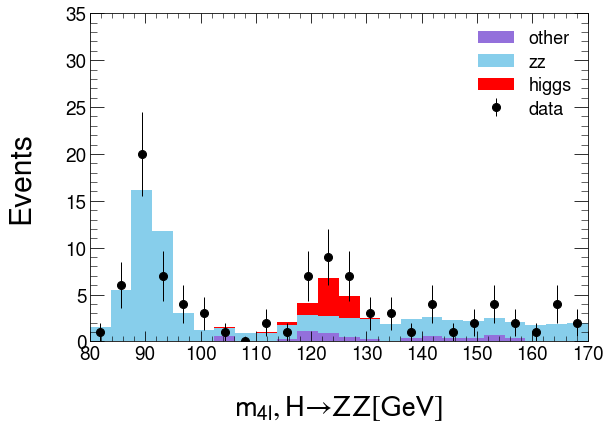

In [12]:
def plot_stacked_hist(zz_factor, higgs_factor):
    main_axes = plt.gca()
    main_axes.errorbar(x=bin_centers, y=data_hist[0], yerr=np.sqrt(data_hist[0]), fmt='ko', label='data')

    # https://matplotlib.org/3.3.0/api/_as_gen/matplotlib.pyplot.hist.html
    # https://matplotlib.org/3.3.0/gallery/statistics/histogram_multihist.html

    main_axes.hist(x=[other_x, zz_x, higgs_x, ], 
                   bins=n_bins, 
                   range=bin_range, 
                   weights=[other_weights, zz_weights*zz_factor, higgs_weights*higgs_factor], 
                   color=['mediumpurple', 'skyblue', 'red'], 
                   label=['other', 'zz', 'higgs'],
                   histtype='bar',
                   stacked=True
                  )

    plt.xlim(bin_range[0], bin_range[1])
    plt.ylim(0, 35)
    plt.xlabel(r'$m_{4l}, H \to ZZ [GeV]$')
    plt.ylabel('Events')
    plt.xticks(np.arange(bin_range[0], bin_range[1]+10, 10))
    plt.legend()

plot_stacked_hist(1.3, 1.0)

t2 = datetime.now()
print(t2)
print('total runtime: {} s'.format((t2-t1).seconds))

## Prepare the pyhf Workspace

Here we define the workspace which will eventually be used by pyhf to give the signal region normalization factor

In [13]:
null = None
pyhf_workspace = \
{
    "channels": [
        {
            "name": "Signal_region",
            "samples": [
                {
                    "data": zz_hist[0].tolist(),
                    "modifiers": [
                        {
                            "data": zz_hist_err.tolist(),
                            "name": "staterror_Signal_region",
                            "type": "staterror"
                        }
                    ],
                    "name": "ZZ"
                },
                {
                    "data": higgs_hist[0].tolist(),
                    "modifiers": [
                        {
                            "data": higgs_hist_err.tolist(),
                            "name": "staterror_Signal_region",
                            "type": "staterror"
                        },
                        {
                            "data": null,
                            "name": "Signal_norm",
                            "type": "normfactor" # free parameter in fit
                        }
                    ],
                    "name": "Higgs"
                },
                {
                    "data": other_hist[0].tolist(),
                    "modifiers": [
                        {
                            "data": other_hist_err.tolist(),
                            "name": "staterror_Signal_region",
                            "type": "staterror"
                        }
                    ],
                    "name": "Other"
                }
            ]
        }
    ],
    "measurements": [
        {
            "config": {
                "parameters": [
                    {
                        "bounds": [
                            [
                                0,
                                5
                            ]
                        ],
                        "inits": [
                            1
                        ],
                        "name": "Signal_norm"
                    }
                ],
                "poi": "Signal_norm"
            },
            "name": "minimal_example"
        }
    ],
    "observations": [
        {
            "data": data_hist[0].tolist(),
            "name": "Signal_region"
        }
    ],
    "version": "1.0.0"
}

with open("higgs4l_pyhf_workspace.json", "w") as outfile:  
    json.dump(pyhf_workspace, outfile, indent=4) 

## Run pyhf Fit

After running the fit, extract the best fit normalization factor

In [14]:
import fit
with open("higgs4l_pyhf_workspace.json") as f:
    ws = json.load(f)

bestfit, uncertainty, labels = fit.fit(ws)

for idx, label in enumerate(labels):
    if label == 'Signal_norm':
        bestfit_norm = bestfit[idx]
    else:
        continue

------------------------------------------------------------------
| FCN = -1.927                  |     Ncalls=638 (638 total)     |
| EDM = 1.87e-06 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
staterror_Signal_region[bin_0] : 0.999370 +/- 0.034122
staterror_Signal_region[bin_1] : 1.000157 +/- 0.017838
staterror_Signal_region[bin_2] : 1.000427 +/- 0.010552
staterror_Signal_region[bin_3] 

## Compare the Original and Normalized Signal Region Histograms

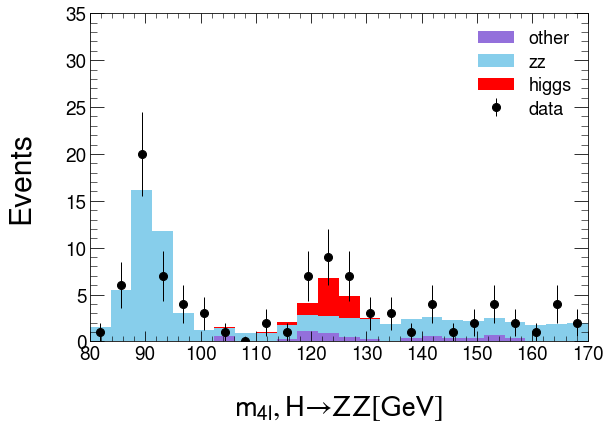

In [15]:
plot_stacked_hist(zz_factor=1.3, higgs_factor=1.0)

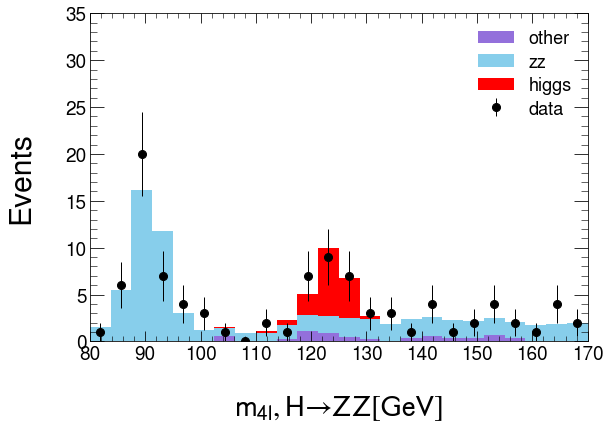

In [16]:
plot_stacked_hist(zz_factor=1.3, higgs_factor=bestfit_norm)

## What's Next?

- Integrate further with Cabinetry framework by using Awkward Arrays instead of Pandas
- Add Systematic Uncertainties (maybe dummy)
- Simultaneously fit zz normalization factor